# RXMCによる[y=ax+b]のfittingとBayes推定
### 行うこと
+ RXMC
+ RXMCの結果からBayes推定(事後確率分布の生成)
 --> まずはここまで

### 00.事前準備
+ 現在位置の確認
+ ディレクトリの生成


In [1]:
####### 操作設定 #######
import os
from jnbayes.libs.etc_sub import make_directory as mk_dir
print("###### start programs ######")
print("NOW CWD is", os.getcwd())

# 各種保存用ディレクトリ作成
print("######### make dirs #########")
mk_dir("./dt/")
mk_dir("./dt/np/")
mk_dir("./dt/json/")
mk_dir("./pic/")
mk_dir("./bayes_log/")




read __init__.py(libs)
###### start programs ######
NOW CWD is c:\Users\rmizuta\Desktop\jnbayes
######### make dirs #########
./dt/ exist!
./dt/np/ exist!
./dt/json/ exist!
./pic/ exist!
./bayes_log/ exist!


### 01.データ生成
+ npyファイルの生成、保存

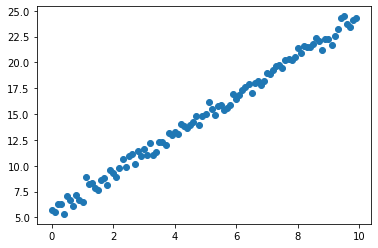

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

n = 100
sigma_R = 0.5#ノイズの標準偏差
x = np.arange(n)/10
a = 1.9
b = 5.5

y = a*x + b + np.random.normal(loc=0, scale=sigma_R,size=n)


data = [x,y]
plt.scatter(x,y)
plt.show()
np.save("dt/np/liner.npy",data)
plt.close()


### 02.パラメータ設定
+ ファイルパスやRXMCのループ数などの設定
+ ハイパーパラメータの設定

bayes_log/liner/ exist!


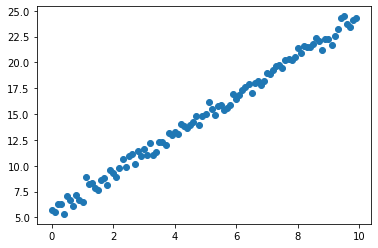

In [3]:
from jnbayes.libs.rxmc_cls import Rxmc_ctrl
from jnbayes.libs.etc_sub import read_xy_slice_data
import json

liner_json_path = "./dt/json/liner_test.json"

liner_json = {
    "dpar": {
        "model_name":"ax1b",        # モデル名
        "dt_file": "dt/np/",        # 元データのパス
        "log_file": "bayes_log/",   # おまじない、bayesのログ保管パス
        "pic_file": "pic/",         # おまじない、画像出力パス
        "dt_name": "liner",         # データ名(拡張子なし)
        "dt_extension": ".npy",     # データ拡張子
        "log_par_rxmc_loops": 1000, # おまじない、RXMCログ保存数
        "bayes_Efree_par_rxmc_loops": 1000 #おまじない、bayes自由エネルギー抽出数
},
    "rpar": {
        "cycle": 5000,              # RXMCサイクル数
        "num_temp": 70,             # レプリカ数
        "proportion": 1.3,          # 逆温度等比級数
        "burn_in_length": 1000      # 焼きなまし回数
    },
    "fpar": {
        "convolve":{"TF":False},    # おまじない、特殊fitting用
        "xlim":[None,None],         # おまじない、fittingのデータ点を切れる
        "noise": {
            "sigmaR": 0.25,         # 推定ノイズ、大体半分の値を入力
            "sigmaE": 1.0           # おまじない、使わない
        },
        "BG": {
            "model": "nothing"      # BGの値、
        },
        "peak": {
            "01": {                 # 第一関数セット、複数セットができる
                "model": "liner",   # 関数名、
                "par": {
                    "init": [
                        2,          # aの初期値
                        5.4         # bの初期値
                    ]
                },
                "hyper": {
                    "step": [
                        7,          # aのC値
                        7           # bのC値
                    ],
                    "alpha": [
                        40000.0,    # aのα値
                        1000.0      # bのα値
                    ],
                    "dd": [
                        0.5,        # aのd値
                        0.5         # bのd値
                    ]
                },
                "limit": {
                    "rng_min": [
                        0,          # aの推定最小値
                        0           # bの推定最小値
                    ],
                    "rng_max": [
                        10,         # aの推定最大値
                        10          # bの推定最大値
                    ]
                }
            }
        }
    }
}

with open(liner_json_path,"w") as fout:
    json.dump(liner_json, fout, indent=4)


#### 上で書いたjsonを専用のクラスで読み込み
rx_cls = Rxmc_ctrl(liner_json_path)

### XYデータ(npyファイル)を読み込み、クラスに登録
read_xy_slice_data(rx_cls, check=False)

### RXMCのログ保存ディレクトリを作成
mk_dir(rx_cls.log_dt_name)

### クラスにXYデータが登録できたか確認
plt.scatter(rx_cls.X,rx_cls.Y)
plt.show()
plt.close()


### 03.RXMC事前準備(rxmc_run.py->run_rxmc()前半)
+ RXMCのパラメータを読み込む
+ 初期値を代入、E(最小二乗誤差)の計算
+ レプリカの作成

In [4]:
from jnbayes.libs.rxmc_sub import get_fitting_container
from jnbayes.libs.rxmc_sub import get_Y
from jnbayes.libs.rxmc_sub import get_Energy


######## read raw data
X = rx_cls.X
Y = rx_cls.Y

######## deploy param to meaningful parameters
dir_dict = rx_cls.df["dpar"]
func_dict = rx_cls.df["fpar"]
run_dict = rx_cls.df["rpar"]

######## read dict
_p_init_ = rx_cls.get_param("par","init")
_step_ = rx_cls.get_param("hyper","step")
_alpha_ = rx_cls.get_param("hyper","alpha")
_d_ = rx_cls.get_param("hyper","dd")
_p_min_ = rx_cls.get_param("limit","rng_min") 
_p_max_ = rx_cls.get_param("limit","rng_max")
log_length = rx_cls.df["dpar"]["log_par_rxmc_loops"]
cycle = run_dict["cycle"]
num_temp = run_dict["num_temp"]
sigmaE = func_dict["noise"]["sigmaE"]    
X_slice = rx_cls.xslice
######## get fitting container
fit_cont, BG_cont = get_fitting_container(func_dict)


######## calc dict
data_len = len(X)
par_num = len(_p_init_)
_p_min_tl_ = np.tile(_p_min_,(num_temp,1))
_p_max_tl_ = np.tile(_p_max_,(num_temp,1))
dt_log_name = rx_cls.logfile_header
if func_dict["convolve"]["TF"]:
    conv_TF = True
else:
    conv_TF = False

######## calc first ones
Yraw = Y.reshape(1,-1)
_p_now_ = np.tile(_p_init_,(num_temp,1))

Ytmp = get_Y(X,_p_now_,fit_cont, BG_cont, conv_TF)

_E_now_ = get_Energy(Yraw,Ytmp,data_len,sigmaE,X_slice)

######## cleate temp
temp, _stepsize_p_ = rx_cls.get_temp_step(par_num,_step_,_alpha_,_d_)


######## define for RXMC
p0_log = np.zeros((num_temp,par_num,log_length),dtype=np.int32)
E0_log = np.zeros((num_temp,log_length),dtype=np.int32)
_p_log_ = 1.0*p0_log
_E_log_ = 1.0*E0_log
_ratio_p_log_ = 0*p0_log
_ratio_exc_rep_log_ = 0*E0_log

### 04.結果の表示(03の)
+ 逆温度の範囲のプロット
+ stepsizeと逆温度のプロット

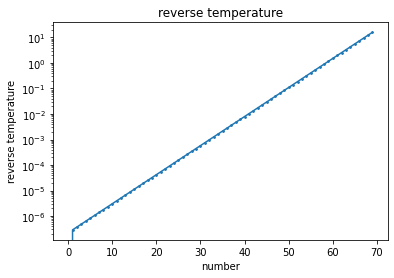

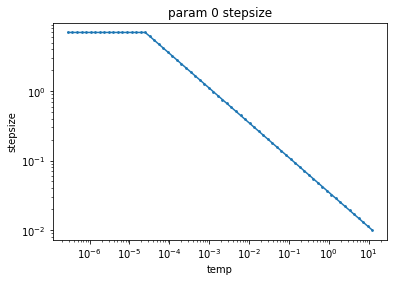

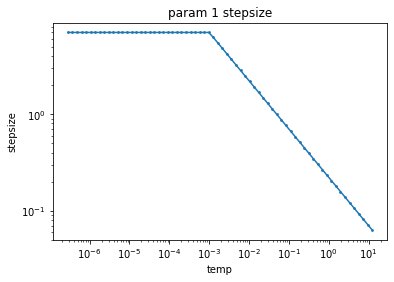

In [6]:
### 逆温度のプロット
temp_range = np.array(range(len(temp)))
plt.plot(temp_range,temp)
plt.scatter(temp_range,temp,s=3)
plt.xlabel("number")
plt.ylabel("reverse temperature")
plt.yscale("log")
plt.title("reverse temperature")
plt.show()
plt.close()


### stepsizeと逆温度のプロット
for ipar in range(len(_stepsize_p_[0])):
    plt.plot(temp[1:-1],_stepsize_p_[1:-1,ipar])
    plt.scatter(temp[1:-1],_stepsize_p_[1:-1,ipar],s=3)
    plt.xlabel("temp")
    plt.ylabel("stepsize")
    plt.xscale("log")
    plt.yscale("log")
    plt.title(f"param {ipar} stepsize")
    plt.show()
    plt.close()


### 05. RXMC開始(rxmc_run.py->run_rxmc()後半)
+ RXMC
+ ログファイルの記入


In [8]:
import time
import gc
from jnbayes.libs.rxmc_sub import update_param
from jnbayes.libs.rxmc_sub import exc_replica
from jnbayes.libs.rxmc_sub import renew_E_log
from jnbayes.libs.rxmc_sub import renew_p_log


tm_start = time.time()



######## event loop <----- MOST IMPORTANT!!!
print("cycle =",cycle)
for icycl in range(cycle):
    
    ########## print progress of RXMC
    if icycl%100==0:
        tm_stop = time.time()
        time_str = str(round(100/(tm_stop-tm_start+(10e-5)),1)) + "Hz"
        print("event loop =",rx_cls.model_name, icycl,time_str)
        tm_start = tm_stop
    log_mod_cycl = icycl%log_length

    ########## update all parameters
    _p_now_, _E_now_ = update_param(icycl,log_length,_E_now_,data_len,sigmaE,X,Yraw,
                    _p_now_,_stepsize_p_,_ratio_p_log_,num_temp,
                    _p_min_tl_,_p_max_tl_,temp,fit_cont, BG_cont,X_slice,conv_TF)
    _p_log_[:,:,log_mod_cycl] = _p_now_

    ########## exchange replica
    exc_replica(icycl,_p_now_,_E_now_,temp,data_len,num_temp,log_mod_cycl,_ratio_exc_rep_log_)
    _E_log_[:,log_mod_cycl] = _E_now_

    ######## save log pars
    if (icycl+1)%log_length == 0:
        loop_num_str = str(int((icycl+1)/log_length)).zfill(3)
        tmp_arg = [num_temp,par_num,log_length]
        _p_log_ = renew_p_log(dt_log_name,loop_num_str,"_p_log_",_p_log_,tmp_arg)
        _E_log_ = renew_E_log(dt_log_name,loop_num_str,"_E_log_",_E_log_,tmp_arg)
        _ratio_p_log_ = renew_p_log(dt_log_name,loop_num_str,"_ratio_p_log_",_ratio_p_log_,tmp_arg)
        _ratio_exc_rep_log_ = renew_E_log(dt_log_name,loop_num_str,"_ratio_exc_rep_log_",_ratio_exc_rep_log_,tmp_arg)
        print("saved log par",log_length,"events")
        gc.collect() #### Garbage Collector cleans memory
print("event loop =",rx_cls.model_name,"F!!!!")

cycle = 5000
event loop = ax1b 0 93739.4Hz
event loop = ax1b 100 2041.0Hz
event loop = ax1b 200 2176.2Hz
event loop = ax1b 300 2223.3Hz
event loop = ax1b 400 2272.4Hz
event loop = ax1b 500 2224.4Hz
event loop = ax1b 600 2175.0Hz
event loop = ax1b 700 2119.4Hz
event loop = ax1b 800 2324.5Hz
event loop = ax1b 900 2164.4Hz
saved log par 1000 events
event loop = ax1b 1000 1082.9Hz
event loop = ax1b 1100 2221.7Hz
event loop = ax1b 1200 2188.2Hz
event loop = ax1b 1300 2209.9Hz
event loop = ax1b 1400 2220.2Hz
event loop = ax1b 1500 2104.6Hz
event loop = ax1b 1600 2128.7Hz
event loop = ax1b 1700 2129.9Hz
event loop = ax1b 1800 2221.7Hz
event loop = ax1b 1900 2223.6Hz
saved log par 1000 events
event loop = ax1b 2000 1273.9Hz
event loop = ax1b 2100 2084.6Hz
event loop = ax1b 2200 2223.4Hz
event loop = ax1b 2300 2179.5Hz
event loop = ax1b 2400 2273.2Hz
event loop = ax1b 2500 2095.7Hz
event loop = ax1b 2600 2167.0Hz
event loop = ax1b 2700 2170.6Hz
event loop = ax1b 2800 2224.9Hz
event loop = ax1b 

### 結果の表示(05の)
+ 全レプリカの全パラメータのログ
+ 全レプリカの最小二乗誤差のログ
+ パラメータ採択率 vs 逆温度
+ レプリカ交換率 vs 逆温度


In [ ]:
import glob

burn_in_length = run_dict["burn_in_length"]
logfile_header = rx_cls.logfile_header

#### パラメータログの描画関数
def plt_p_log(tmp_log,pic_name,par_num):
    np_nums = np.arange(len(tmp_log))
    plt.figure(figsize=(15,5))
    plt.title(pic_name)
    plt.subplot(1,2,1)
    plt.scatter(np_nums,tmp_log)
    plt.ylabel(f"par{par_num}")
    plt.xlabel("Iteration number")
    plt.subplot(1,2,2)
    plt.hist(tmp_log,bins=40)
    plt.xlabel(f"par{par_num}")
    plt.ylabel("Cnt")
    plt.show()
    plt.close()


##### 全レプリカの全パラメータのログ
p_log_files = glob.glob(logfile_header+"_p_log_*.npy") # globでファイルサーチ
p_log_files = sorted(p_log_files)
p_log = np.empty((num_temp,par_num,0))
for i in range(len(p_log_files)):
    tfile = p_log_files[i]
    np_tmp = np.load(tfile,allow_pickle=True)
    p_log = np.append(p_log,np_tmp,axis=2)
for irep in range(num_temp):
    for ipar in range(par_num):
        tmp_p_log = p_log[irep][ipar][burn_in_length:]
        pic_name = f"par{ipar}, rep{irep}"
        plt_p_log(tmp_p_log,pic_name,ipar)
del p_log
gc.collect()



#### エネルギーログの描画関数
def plt_E_log(tmp_log,pic_name):
    np_nums = np.arange(len(tmp_log))
    plt.figure(figsize=(15,5))
    plt.title(pic_name)
    plt.subplot(1,2,1)
    plt.scatter(np_nums,tmp_log)
    plt.ylabel("E")
    plt.xlabel("Iteration number")
    plt.subplot(1,2,2)
    plt.hist(tmp_log,bins=40)
    # plt.yscale("log")
    plt.xlabel("E")
    plt.ylabel("Cnt")    



##### 全レプリカのエネルギーのログ
E_log_files = glob.glob(logfile_header+"_E_log_*.npy")
E_log_files = sorted(E_log_files)
E_log = np.empty((num_temp,0))
for ifile in range(len(E_log_files)):
    tfile = E_log_files[ifile]
    tmp = np.load(tfile,allow_pickle=True)
    E_log = np.append(E_log,tmp,axis=1)
for irep in range(num_temp):
    pic_name = f"rep{irep}"
    
    tmp_E_log = E_log[irep][burn_in_length:]
del E_log
gc.collect()









